In [1]:
import os
import pandas
import matplotlib.pyplot as plt
import seaborn
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CelebA
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

plt.rcParams["savefig.bbox"] = 'tight'

In [2]:
class CNN_CelebA(nn.Module):
    def __init__(self):
        super(CNN_CelebA, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 256, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(256, 512, kernel_size= 3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Flatten()
        )

        self.z_mean = nn.Linear(512*4, 128)
        self.z_log_var = nn.Linear(512*4, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 512*4),
            nn.Unflatten(1, (512, 2, 2)),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),            
            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 3, kernel_size= 3, padding= 1),
            nn.Tanh()
        )

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.z_mean(enc)
        lv = self.z_log_var(enc)
        lat = self.reparam(mu, lv)
        dec = self.decoder(lat)
        
        return dec, mu, lv

    def reparam(self, mu, lv):
        std = torch.exp(0.5 * lv)
        eps = torch.randn_like(std)
        return mu + std * eps

In [3]:
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(148),
        transforms.Resize(64),
        transforms.ToTensor()
    ]
)

trainset = CelebA(root='/media/airesearch/khoibaocon/git/data', split='train', download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=24)
validset = CelebA(root='/media/airesearch/khoibaocon/git/data', split='valid', download=True, transform=transform)
valid_dl = DataLoader(validset, batch_size=64, shuffle=False, num_workers=24)
testset = CelebA(root='/media/airesearch/khoibaocon/git/data', split='test', download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=64, shuffle=False, num_workers=24)

print(len(trainset), len(validset), len(testset))
print(len(train_dl), len(valid_dl), len(test_dl))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
162770 19867 19962
2544 311 312


In [4]:
def gaussian_kls(mu, logvar):
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    return torch.mean(kld_loss)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_CelebA().to(device)

optimizer = Adam(params = model.parameters(), lr = 0.005)

epochs = 30

kld_w = 64/len(trainset)

scheduler = CosineAnnealingLR(optimizer, epochs*len(train_dl))

recon_loss = nn.MSELoss(reduction='none')

def loss_fn(recon_x, x):
    return torch.mean(torch.sum(recon_loss(recon_x, x), dim=(1,2,3)))

In [6]:
for epoch in range(epochs):
    model.train()
    tr_total_loss = {
        "rec_loss" : 0,
        "kl_loss" : 0
    }
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img, train_mu, train_lv = model(train_img)
        train_rec_loss = loss_fn(gen_img, train_img)
        train_kl_loss = gaussian_kls(train_mu, train_lv)
        train_loss = train_rec_loss + kld_w * train_kl_loss

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        scheduler.step()

        tr_total_loss["rec_loss"] += train_rec_loss.item()
        tr_total_loss["kl_loss"] += train_kl_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = {
            "rec_loss" : 0,
            "kl_loss" : 0
        }
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img, valid_mu, valid_lv = model(valid_img)
            valid_rec_loss = loss_fn(gen_img, valid_img)
            valid_kl_loss = gaussian_kls(valid_mu, valid_lv)
            valid_loss = valid_rec_loss + valid_kl_loss

            va_total_loss["rec_loss"] += valid_rec_loss.item()
            va_total_loss["kl_loss"] += valid_kl_loss.item()

    print(f"Epoch: {epoch} - TrainRecLoss: {tr_total_loss['rec_loss']/len(train_dl)} - ValidRecLoss: {va_total_loss['rec_loss']/len(test_dl)}")
    print(f"Epoch: {epoch} - TrainDivLoss: {tr_total_loss['kl_loss']/len(train_dl)} - ValidDivLoss: {va_total_loss['kl_loss']/len(test_dl)}")

100%|██████████████████████████████████████████████████████████████████| 312/312 [00:31<00:00,  9.93it/s]


Epoch: 0 - TrainRecLoss: 371.01717538053884 - ValidRecLoss: 233.5036390744723
Epoch: 0 - TrainDivLoss: 11192180.046011282 - ValidDivLoss: 4778.642031938602


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:30<00:00, 10.14it/s]


Epoch: 1 - TrainRecLoss: 204.53392753960952 - ValidRecLoss: 169.61901860359387
Epoch: 1 - TrainDivLoss: 5764.139097009815 - ValidDivLoss: 6263.026655148237


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:34<00:00,  9.08it/s]


Epoch: 2 - TrainRecLoss: 164.53080877867885 - ValidRecLoss: 180.63263961596365
Epoch: 2 - TrainDivLoss: 7702.09724378286 - ValidDivLoss: 820570.4383810973


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:30<00:00, 10.37it/s]


Epoch: 3 - TrainRecLoss: 142.31853916360149 - ValidRecLoss: 124.11574850326929
Epoch: 3 - TrainDivLoss: 7158.395516257616 - ValidDivLoss: 7150.3770313752


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:35<00:00,  8.76it/s]


Epoch: 4 - TrainRecLoss: 119.10425604514356 - ValidRecLoss: 107.21442630963448
Epoch: 4 - TrainDivLoss: 7331.494083236598 - ValidDivLoss: 7272.934200971555


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:34<00:00,  8.95it/s]


Epoch: 5 - TrainRecLoss: 103.21608331668303 - ValidRecLoss: 92.98705321091872
Epoch: 5 - TrainDivLoss: 6881.235868058115 - ValidDivLoss: 6487.405112242087


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:30<00:00, 10.25it/s]


Epoch: 6 - TrainRecLoss: 96.45669885251507 - ValidRecLoss: 85.33948003328763
Epoch: 6 - TrainDivLoss: 5943.617054681358 - ValidDivLoss: 5694.768304286859


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:30<00:00, 10.32it/s]


Epoch: 7 - TrainRecLoss: 85.27517255447195 - ValidRecLoss: 80.30021745730669
Epoch: 7 - TrainDivLoss: 4880.937831470801 - ValidDivLoss: 4128.228643955328


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:37<00:00,  8.36it/s]


Epoch: 8 - TrainRecLoss: 77.4509989900409 - ValidRecLoss: 73.88109688881116
Epoch: 8 - TrainDivLoss: 3732.5267684264754 - ValidDivLoss: 3188.9403647398335


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:36<00:00,  8.51it/s]


Epoch: 9 - TrainRecLoss: 71.77097437066853 - ValidRecLoss: 65.47049471048209
Epoch: 9 - TrainDivLoss: 2604.131112728479 - ValidDivLoss: 2170.5365635798526


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:33<00:00,  9.19it/s]


Epoch: 10 - TrainRecLoss: 66.80702205873885 - ValidRecLoss: 62.879945803911255
Epoch: 10 - TrainDivLoss: 1943.9722191192818 - ValidDivLoss: 1766.8455438858423


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:33<00:00,  9.43it/s]


Epoch: 11 - TrainRecLoss: 63.11577661682225 - ValidRecLoss: 59.80567932128906
Epoch: 11 - TrainDivLoss: 1610.006365794056 - ValidDivLoss: 1496.6749150202825


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:32<00:00,  9.47it/s]


Epoch: 12 - TrainRecLoss: 60.03363000072024 - ValidRecLoss: 56.806935237004204
Epoch: 12 - TrainDivLoss: 1416.7510817425805 - ValidDivLoss: 1327.7259674072266


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:30<00:00, 10.09it/s]


Epoch: 13 - TrainRecLoss: 57.38064273648292 - ValidRecLoss: 54.1679681631235
Epoch: 13 - TrainDivLoss: 1274.6073356484467 - ValidDivLoss: 1225.1287661821414


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:38<00:00,  8.02it/s]


Epoch: 14 - TrainRecLoss: 55.2024342443958 - ValidRecLoss: 52.493027198009
Epoch: 14 - TrainDivLoss: 1180.1731514121002 - ValidDivLoss: 1120.7448558318308


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:43<00:00,  7.22it/s]


Epoch: 15 - TrainRecLoss: 53.5550863292982 - ValidRecLoss: 50.86089864143958
Epoch: 15 - TrainDivLoss: 1114.7910279567886 - ValidDivLoss: 1073.2837518545298


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:30<00:00, 10.19it/s]


Epoch: 16 - TrainRecLoss: 52.228143678521214 - ValidRecLoss: 50.18858734766642
Epoch: 16 - TrainDivLoss: 1056.523658440548 - ValidDivLoss: 1041.4892053848657


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:26<00:00, 11.75it/s]


Epoch: 17 - TrainRecLoss: 50.70815919330285 - ValidRecLoss: 48.18282436713194
Epoch: 17 - TrainDivLoss: 1006.804291443255 - ValidDivLoss: 992.4161562797351


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:22<00:00, 13.60it/s]


Epoch: 18 - TrainRecLoss: 49.45109938375605 - ValidRecLoss: 47.204987110235756
Epoch: 18 - TrainDivLoss: 964.3822446379272 - ValidDivLoss: 943.3632309742463


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:32<00:00,  9.73it/s]


Epoch: 19 - TrainRecLoss: 48.582104395020686 - ValidRecLoss: 46.840728796445404
Epoch: 19 - TrainDivLoss: 924.5763192086849 - ValidDivLoss: 908.8194161439553


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:36<00:00,  8.53it/s]


Epoch: 20 - TrainRecLoss: 47.92353855438952 - ValidRecLoss: 45.852625284439476
Epoch: 20 - TrainDivLoss: 889.1708778285381 - ValidDivLoss: 869.9832775409405


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:29<00:00, 10.58it/s]


Epoch: 21 - TrainRecLoss: 47.36310663013338 - ValidRecLoss: 45.55099675594232
Epoch: 21 - TrainDivLoss: 854.0209905756344 - ValidDivLoss: 838.2636845906576


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:27<00:00, 11.48it/s]


Epoch: 22 - TrainRecLoss: 46.87357230606319 - ValidRecLoss: 44.89524030685425
Epoch: 22 - TrainDivLoss: 824.6003412930471 - ValidDivLoss: 804.0670598347982


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:32<00:00,  9.66it/s]


Epoch: 23 - TrainRecLoss: 46.4426645362902 - ValidRecLoss: 44.705934536762726
Epoch: 23 - TrainDivLoss: 797.8562766980825 - ValidDivLoss: 785.426873427171


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:29<00:00, 10.66it/s]


Epoch: 24 - TrainRecLoss: 46.119955746632705 - ValidRecLoss: 44.59815409244635
Epoch: 24 - TrainDivLoss: 774.884057770735 - ValidDivLoss: 765.6607480171399


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:22<00:00, 14.05it/s]


Epoch: 25 - TrainRecLoss: 45.856269903902735 - ValidRecLoss: 44.44030964680207
Epoch: 25 - TrainDivLoss: 757.6305282160921 - ValidDivLoss: 749.9931270892804


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:23<00:00, 13.40it/s]


Epoch: 26 - TrainRecLoss: 45.64913658975805 - ValidRecLoss: 44.21275415176
Epoch: 26 - TrainDivLoss: 744.7653171371364 - ValidDivLoss: 737.9526474781526


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:28<00:00, 11.03it/s]


Epoch: 27 - TrainRecLoss: 45.5005281481353 - ValidRecLoss: 44.11481106586945
Epoch: 27 - TrainDivLoss: 735.5096243132585 - ValidDivLoss: 723.120827699319


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:23<00:00, 13.32it/s]


Epoch: 28 - TrainRecLoss: 45.39572019996883 - ValidRecLoss: 44.079288384853264
Epoch: 28 - TrainDivLoss: 730.5077668196001 - ValidDivLoss: 730.4559247921675


100%|██████████████████████████████████████████████████████████████████| 312/312 [00:30<00:00, 10.30it/s]

Epoch: 29 - TrainRecLoss: 45.34576964378357 - ValidRecLoss: 44.08021121147351
Epoch: 29 - TrainDivLoss: 729.0085485926214 - ValidDivLoss: 725.4087498982748


In [10]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(40, 40))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

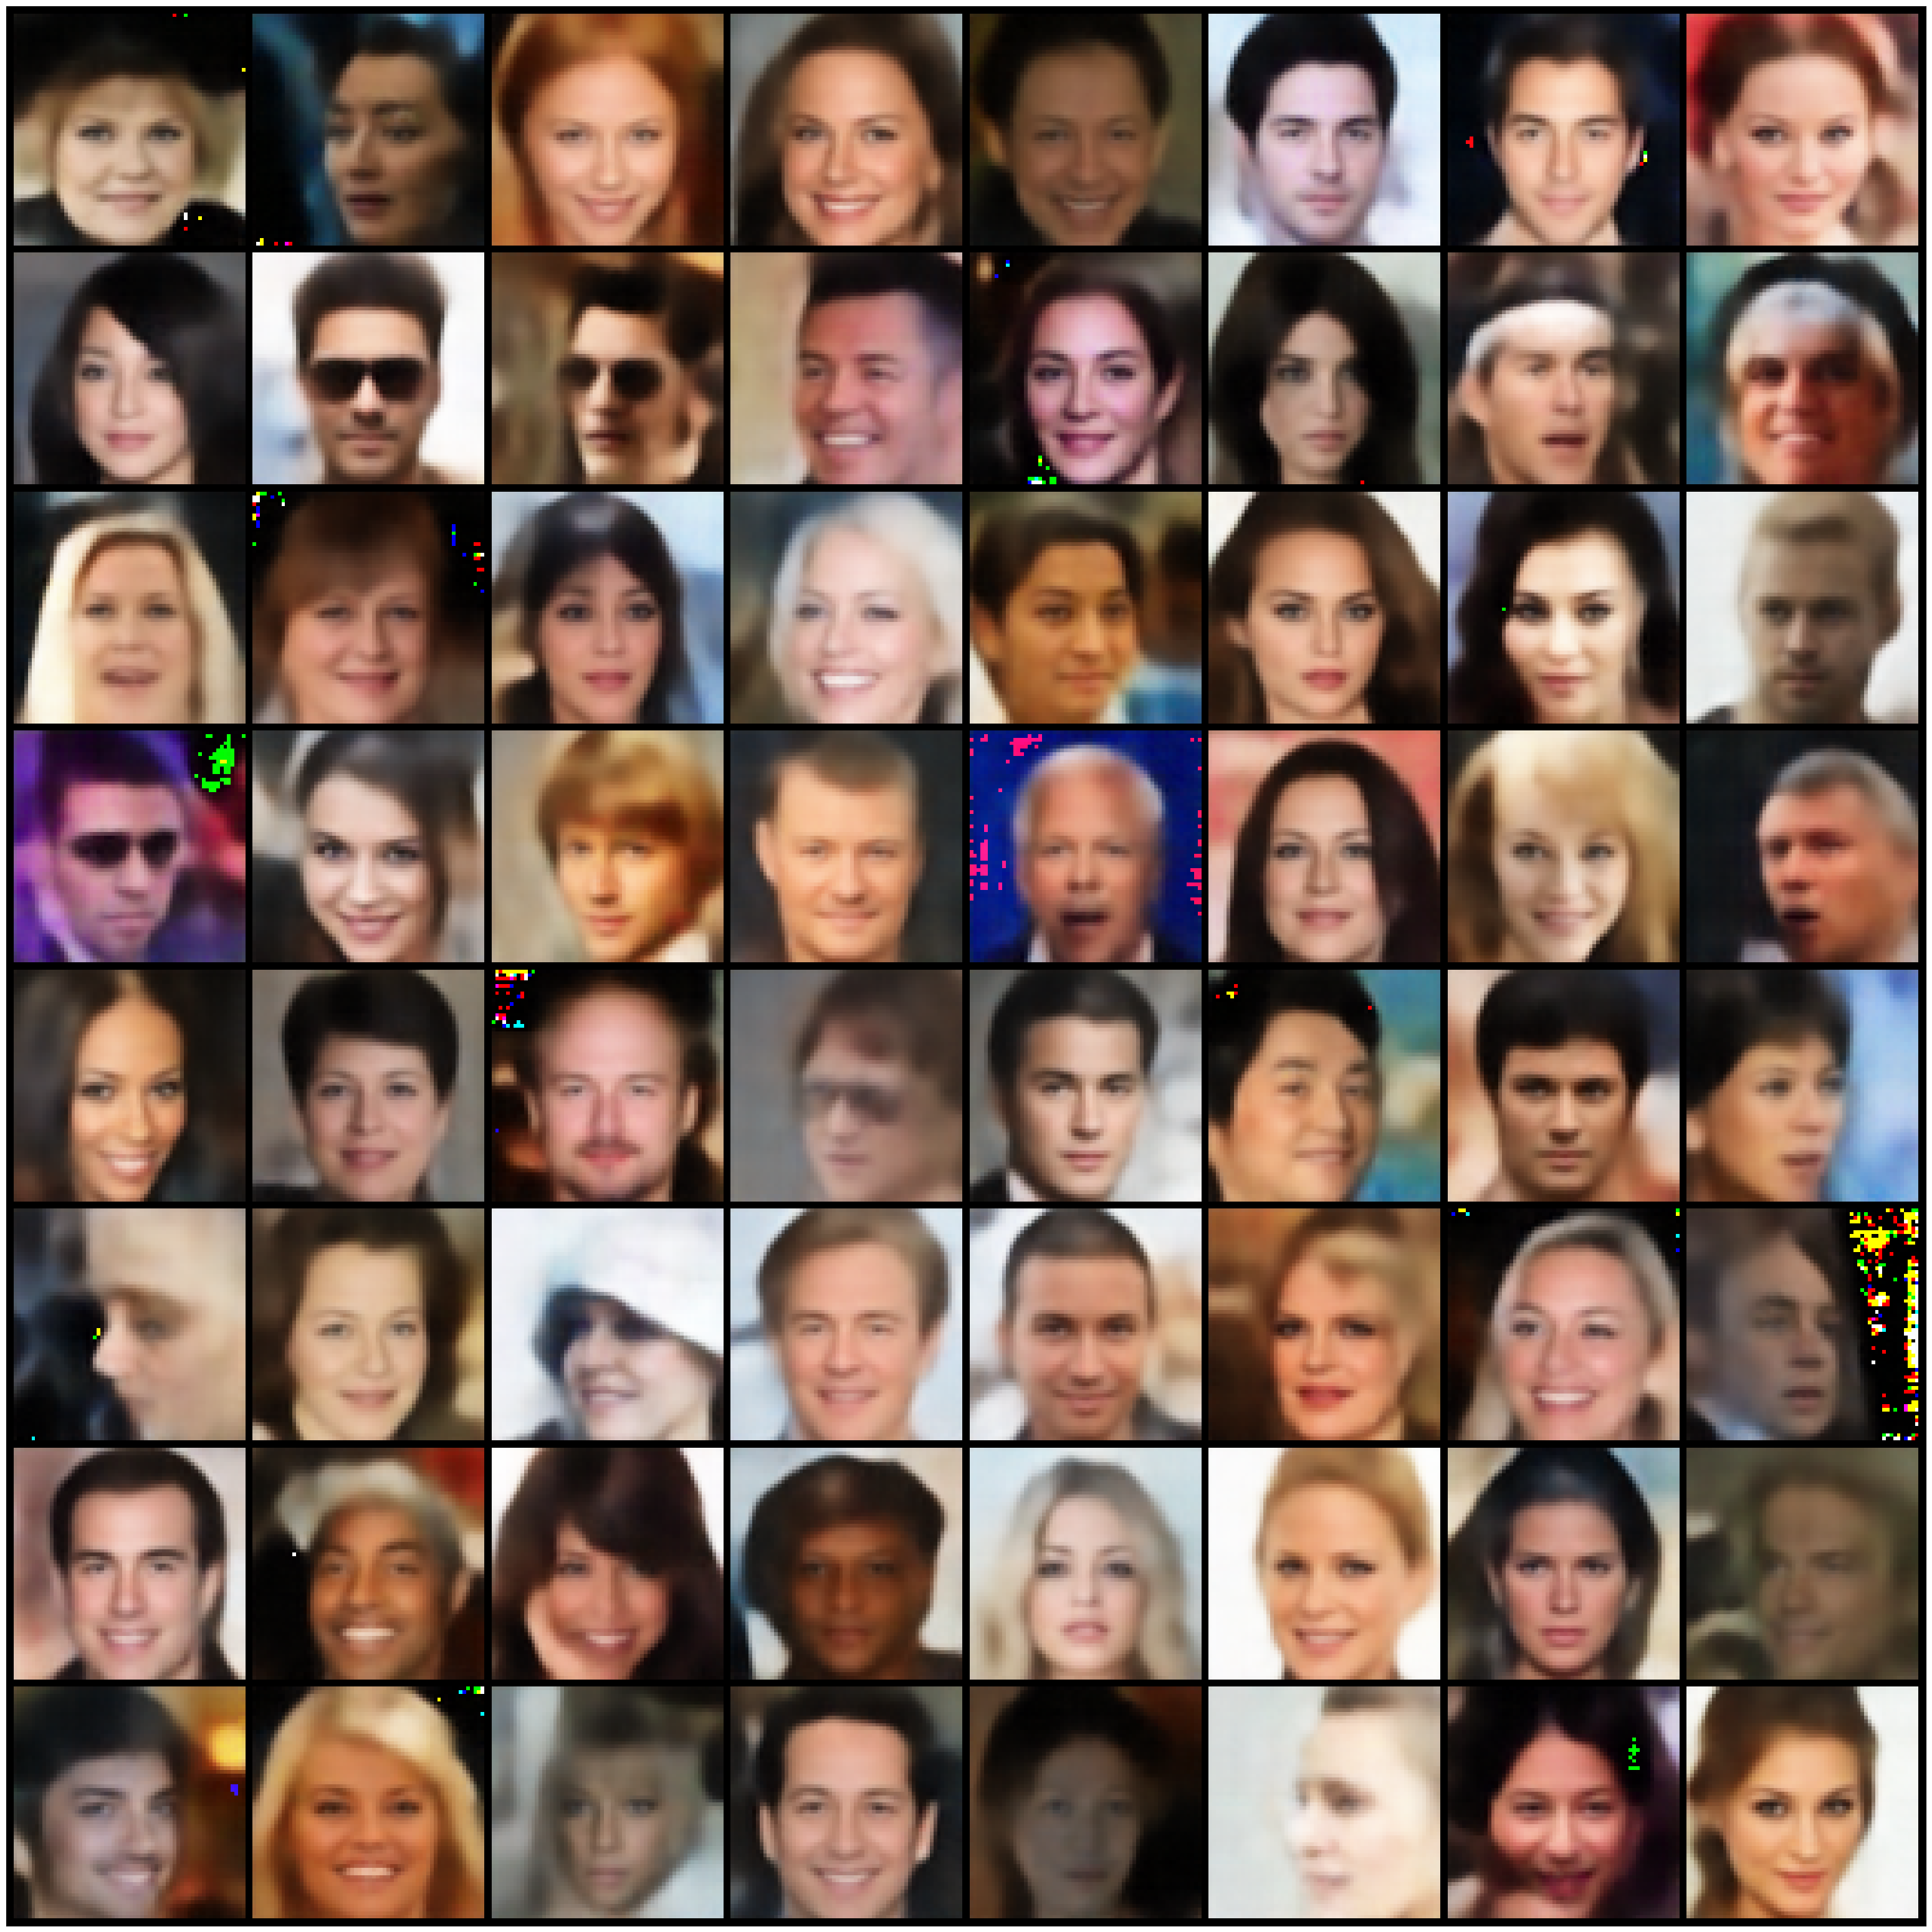

In [11]:
test_input, _ = next(iter(test_dl))
test_input = test_input.to(device)

model.eval()
with torch.no_grad():
    recons, _, _ = model(test_input)

grid = make_grid(recons)
show(grid)

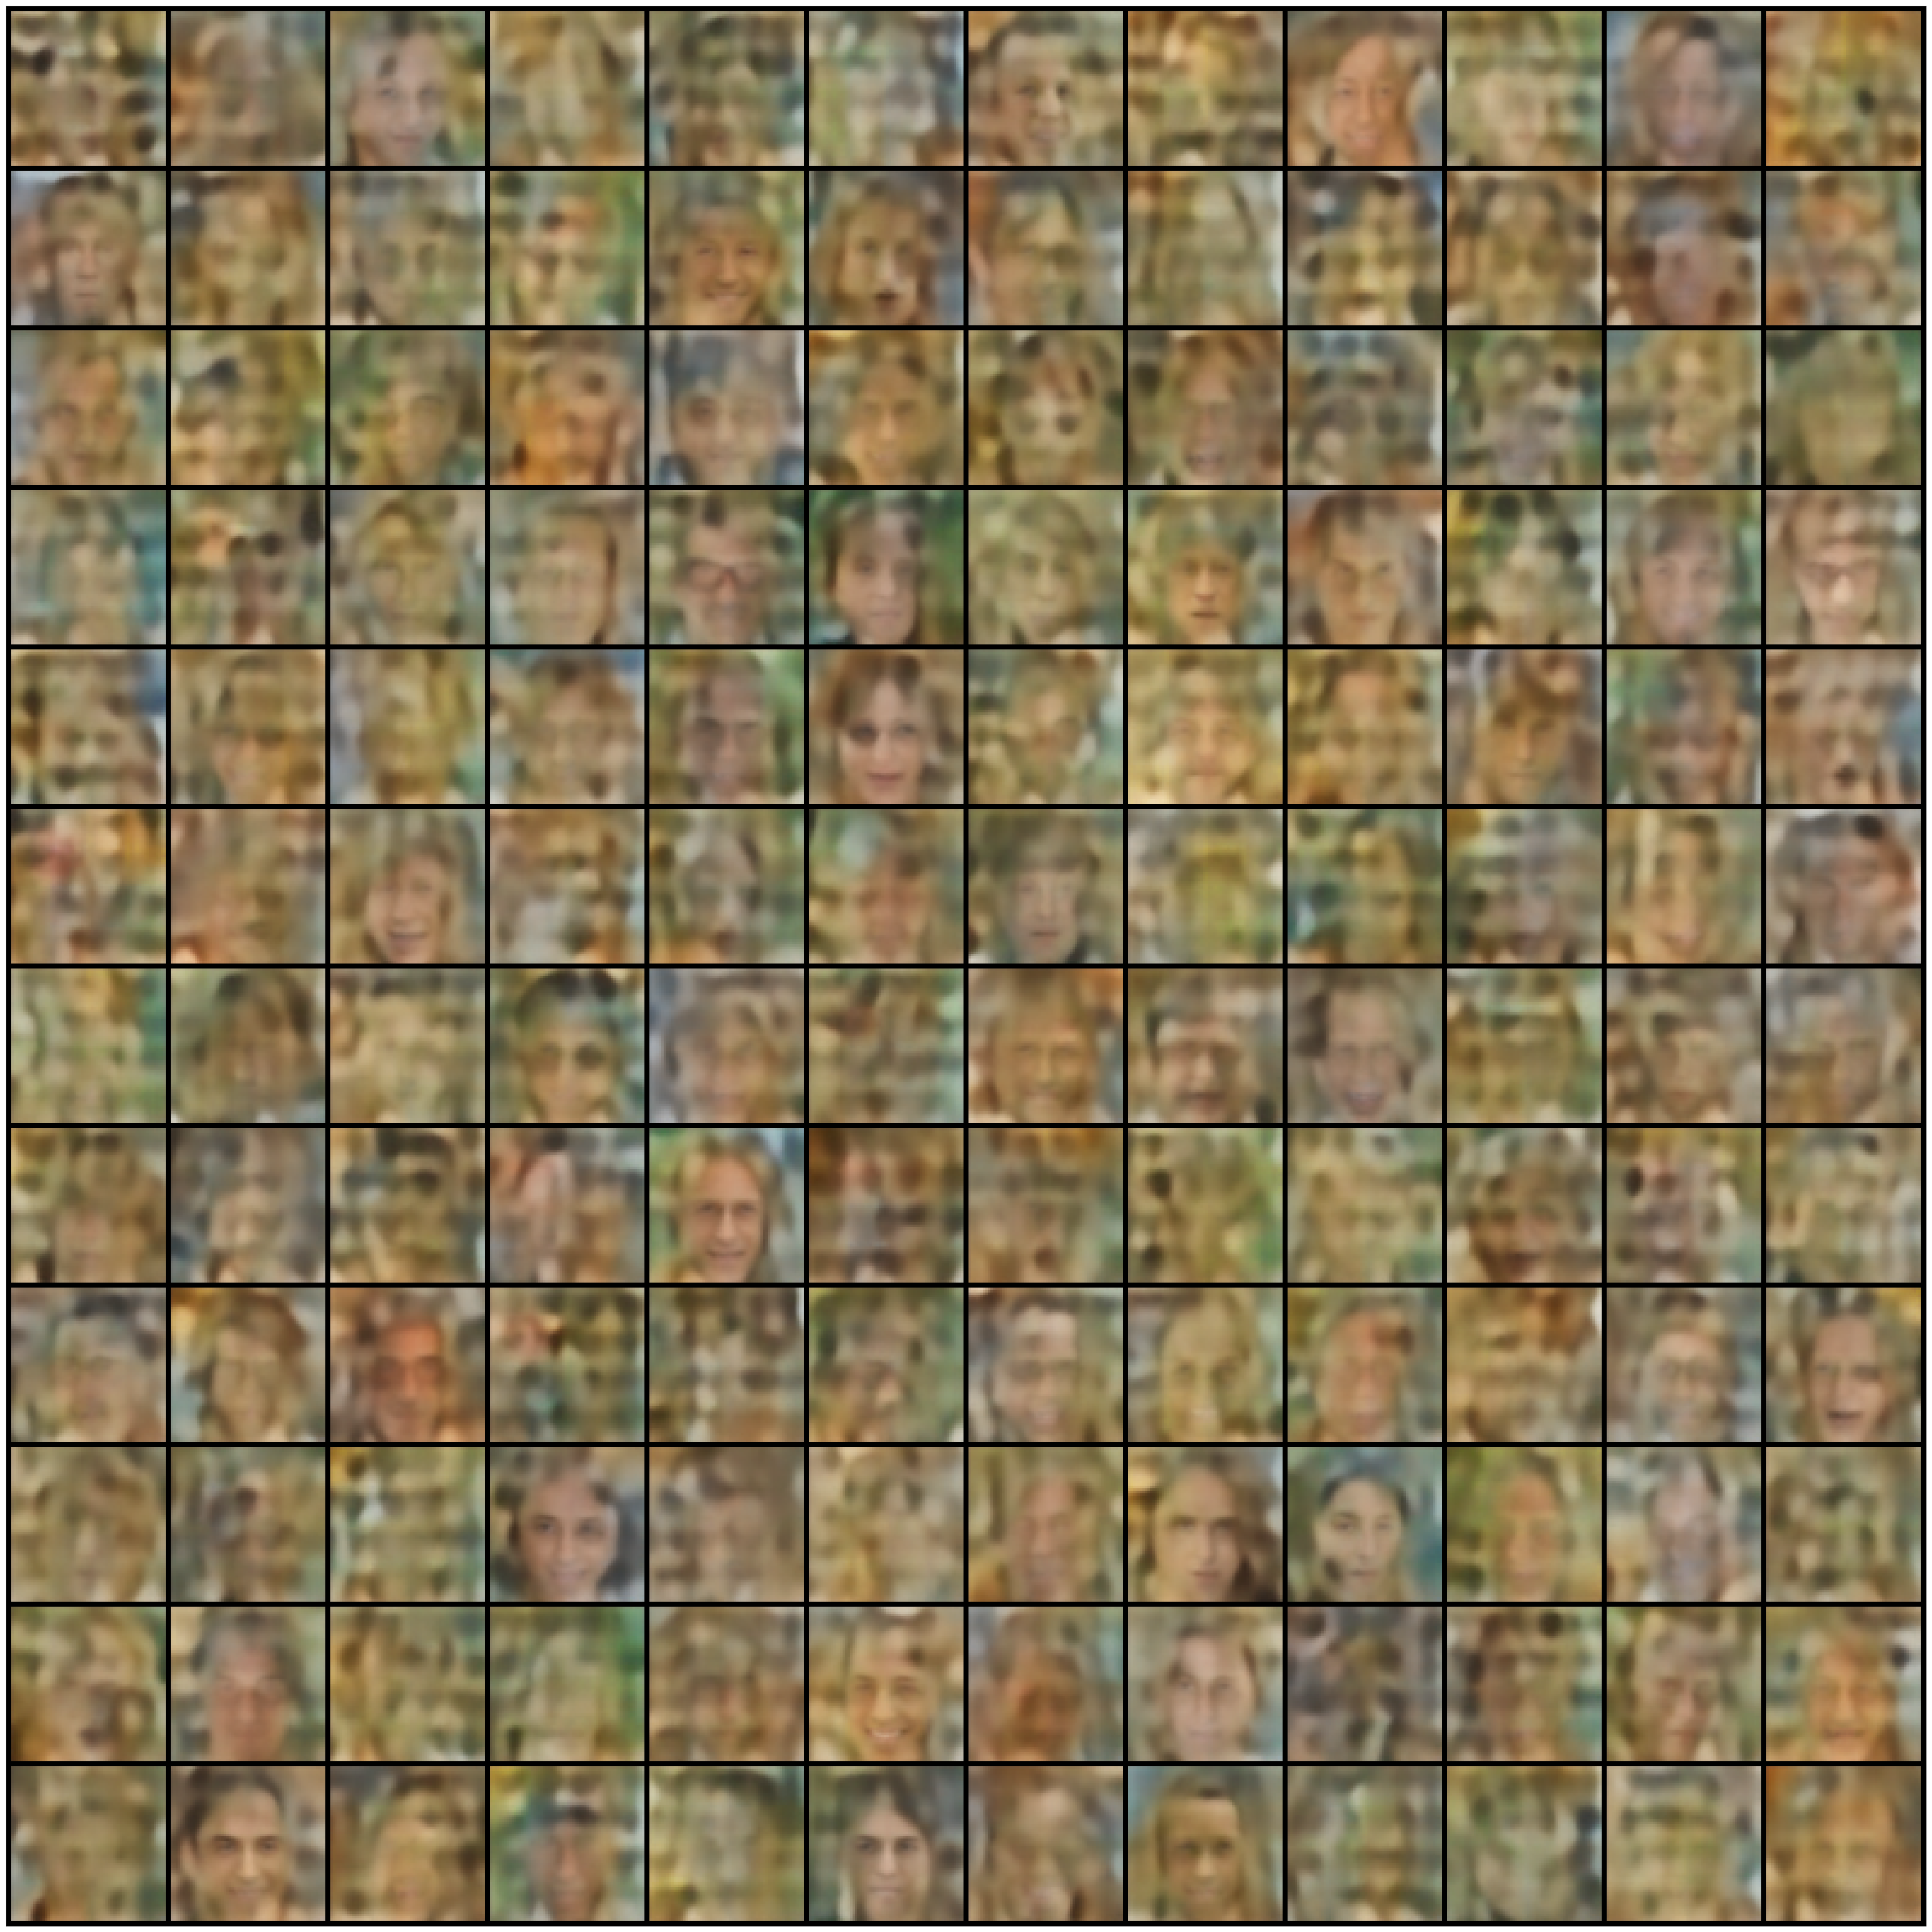

In [12]:
z = torch.randn(144, 128).to(device)

samples = model.decoder(z)

grid = make_grid(samples, nrow=12)
show(grid)